# Project : Evaluation Support Script

This file will contain some supporting functions that will help you evaluate your model. It will show how the validation_grasp_labels.json and validation_object_labels.json can be read in and grasps and object bounding boxes can be drawn on images. It will also show how to convert a grasp in (u, v, width, angle) format into a grasp rectangle prediction.



## Reading in ground-truth labels and visualising on images

In [ ]:
# !mkdir /content/data
# !gdown --id 1xcFdjwDgLKRS1z9Nm33fJzvY9dN4yCBU
# !unrar x '/content/Project_cv1.rar' /content/data

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/data/Project_cv1

/content/data/Project_cv1




---



In [2]:
import json

#read in test information
with open('validation_prompts.json','r') as f:
    val_prompts = json.load(f)

#read in gt grasp labels
with open('validation_grasp_labels.json', 'r') as f:
    gt_grasps = json.load(f)

#read in gt object labels
with open('validation_object_labels.json', 'r') as f:
    gt_objects = json.load(f)

In [3]:
test = 'test_1'

file_name, object = val_prompts[test]
_, _, bbox = gt_objects[test]
grasps = gt_grasps[test]

print(f'Testing {file_name} for {object}')
print(f'GT bbox is {bbox}')
print(f'{len(grasps)} possible grasps exist.')

Testing Graspnet_subset/validation_scenes/scene_0050/rgb/0003.png for banana
GT bbox is [376, 127, 501, 395]
2042 possible grasps exist.


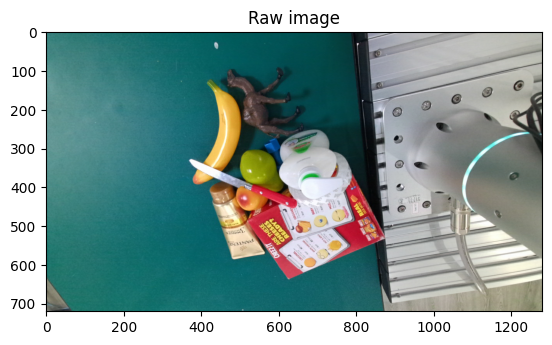

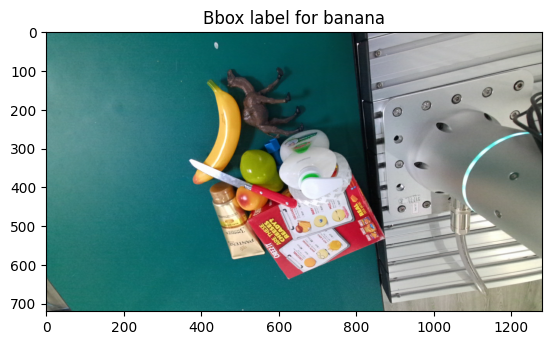

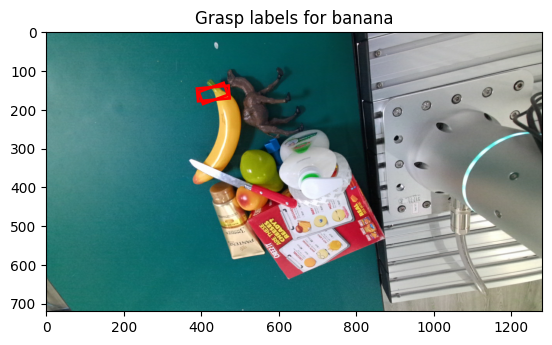

In [4]:
import matplotlib.patches as patches
import cv2
import matplotlib.pyplot as plt

def visualise_image(file_name=None,image_rgb=None ,polygons = [], caption = ''):
    # This function will visualise an image and a set of provided polygons on the image in red. Image title will be set to caption.
    # Polygons must be described by the points to draw between -- for our application, input the 4 corners of a box.

    #load image and convert to RGB
    if file_name:
        im_rgb = cv2.imread(file_name)
        im_rgb = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2RGB)
    else:
        im_rgb = image_rgb

    #create a plot and draw the image
    fig, ax = plt.subplots()
    ax.imshow(im_rgb)

    for p in polygons:
        #draw each polygon in the list with a red edge and linewidth 2
        patch = patches.Polygon(p, closed=True, edgecolor='red', linewidth=2, fill=None)
        ax.add_patch(patch)

    ax.set_title(caption)

    plt.show()

#draw the raw image
visualise_image(file_name, caption = 'Raw image')

#draw the bbox on the image. It must be converted from current format [xmin, ymin, xmax, ymax] into a list with all 4 corner coordinates.
polygon_bbox = [[bbox[0], bbox[1]], [bbox[2], bbox[1]], [bbox[2], bbox[3]], [bbox[0], bbox[3]]]
visualise_image(file_name, [polygon_bbox], caption = f'Bbox label for {object}')

#draw the grasps on the image
visualise_image( file_name = file_name,
                 polygons=[grasps[0],grasps[1]],
                 caption = f'Grasp labels for {object}'
                 )

---
## Convert a grasp in (u, v, width, angle) format into a grasp rectangle prediction.

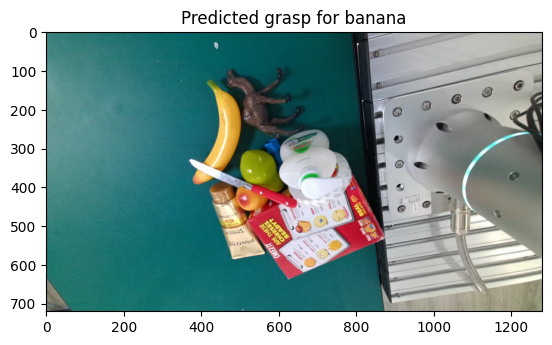

In [5]:
import math

def get_rotated_rectangle_corners(center_x, center_y, width, angle_rad):
    # Given a grasp prediction in the format required by the assignment, this function will convert it into
    # 4 rotated rectangle corners that can be drawn onto an image and visualised. Or compared with a GT grasp
    # for performance evaluation.

    #height is fixed based on the gripper
    height = 30

    # Extract center coordinates
    cx, cy = center_x, center_y

    # Calculate half dimensions
    half_width = width / 2
    half_height = height / 2

    # Calculate the original corner positions relative to the center
    corners = [
        (-half_width, -half_height),  # Bottom-left
        (half_width, -half_height),   # Bottom-right
        (half_width, half_height),    # Top-right
        (-half_width, half_height)    # Top-left
    ]

    # Apply rotation and translation to each corner
    rotated_corners = []
    for x, y in corners:
        # Calculate rotated positions
        rotated_x = cx + (x * math.cos(angle_rad)) - (y * math.sin(angle_rad))
        rotated_y = cy + (x * math.sin(angle_rad)) + (y * math.cos(angle_rad))
        rotated_corners.append((rotated_x, rotated_y))

    return rotated_corners


u = 480
v = 250
width = 120
angle = 0.5

predicted_grasp_rect = get_rotated_rectangle_corners(u, v, width, angle)
#draw the predicted grasp on the image.
polygon_bbox = [[bbox[0], bbox[1]], [bbox[2], bbox[1]], [bbox[2], bbox[3]], [bbox[0], bbox[3]]]
visualise_image(file_name, [predicted_grasp_rect], caption = f'Predicted grasp for {object}')





---
# Start


**mug, banana, bowl, scissors, computer mouse, knife**

In [9]:
from torchvision.io.image import read_image

from torchvision.models.detection import (
                                          fasterrcnn_resnet50_fpn_v2,
                                          FasterRCNN_ResNet50_FPN_V2_Weights,
                                          fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights,
                                          retinanet_resnet50_fpn_v2,
                                          RetinaNet_ResNet50_FPN_V2_Weights

                                          )

from torchvision.models.detection import (
                                          maskrcnn_resnet50_fpn_v2,
                                          MaskRCNN_ResNet50_FPN_V2_Weights
                                          )

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image
import torchvision
import torch
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import cv2
import os
import pandas as pd
import glob




---

# GraspDataset(Dataset)

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import json
import os
import math

class GraspDataset(Dataset):
    def __init__(self, data_dir, prompts_file, grasps_file, objects_file, transform=None):
        """
        Args:
            data_dir (str): Path to the main directory containing images and JSON files.
            prompts_file (str): Path to the JSON file containing scene instructions.
            grasps_file (str): Path to the JSON file containing grasp poses.
            objects_file (str): Path to the JSON file containing object bounding boxes.
            transform (callable, optional): Data transformations (such as image augmentations).
        """
        # Load the JSON files
        with open(prompts_file, 'r') as f:
            self.prompts = json.load(f)

        with open(grasps_file, 'r') as f:
            self.grasp_corners = json.load(f)

        with open(objects_file, 'r') as f:
            self.objects = json.load(f)

        self.data_dir = data_dir
        self.transform = transform


        for key in list(self.prompts.keys()):
          if len(self.objects[key][2]) == 0 or len(self.grasp_corners[key]) == 0:
            self.prompts.pop(key)
            self.grasp_corners.pop(key)
            self.objects.pop(key)


        self.scene_keys = list(self.prompts.keys())  # List of scene names


    def __len__(self):
        """Return the number of scenes in the dataset."""
        return len(self.scene_keys)

    def __getitem__(self, idx):
        """
        Retrieve one scene from the dataset.

        Args:
            idx (int): The index of the scene.

        Returns:
            dict: A dictionary containing:
                  - 'image': The RGB image (torch.Tensor).
                  - 'depth': The depth image (torch.Tensor).
                  - 'bbox': The bounding box of the object (list of coordinates).
                  - 'grasp_corners': Grasp poses as rectangle corners (list of points).
                  - 'grasp_attributes': Grasp poses in (center_x, center_y, width, angle_rad) format.
                  - 'label': The required object class.
        """
        # Get the scene key based on the index
        scene_key = self.scene_keys[idx]

        # Retrieve file name and target label from prompts
        file_name = self.prompts[scene_key][0]
        target_label = self.prompts[scene_key][1]  # The object to grasp

        if target_label == 'mug':
            target_label = 'cup'
        elif target_label == 'computer mouse':
            target_label = 'mouse'


        # Retrieve grasp points (corners) and bounding box
        grasp_corners = self.grasp_corners.get(scene_key, [])
        bbox = self.objects.get(scene_key, [])[2]  # Object bounding box

        # Construct paths to the RGB and depth images
        rgb_image_path = os.path.join(self.data_dir, file_name)
        depth_image_path = rgb_image_path.replace('rgb', 'depth')  # Replace 'rgb' with 'depth' to get the depth path

        # Load the RGB and depth images
        rgb_image = Image.open(rgb_image_path).convert('RGB')
        depth_image = Image.open(depth_image_path).convert('L')  # 'L' mode for single-channel grayscale image

        # Apply transformations if provided
        if self.transform:
            rgb_image = self.transform(rgb_image)
            depth_image = self.transform(depth_image)

        # Convert grasp points (corners) to grasp format (center_x, center_y, width, angle_rad)
        grasp_attributes = []
        for corners in grasp_corners:
            grasp = self.rectangle_corners_to_grasp(corners)
            grasp_attributes.append(grasp)

        # Return the scene data in a dictionary format
        return {
            'image': rgb_image,  # RGB image already transformed to tensor if applicable
            'depth': depth_image,
            'bbox': torch.tensor(bbox, dtype=torch.float32),
            'grasp_corners': torch.tensor(grasp_corners, dtype=torch.float32),  # Grasp corners
            'grasp_attributes': torch.tensor(grasp_attributes, dtype=torch.float32),
            'label': target_label
        }

    def rectangle_corners_to_grasp(self, corners):
        """
        Convert rectangle corners to a grasp format.

        Args:
            corners (list): List of 4 corners (each corner is [x, y]).

        Returns:
            tuple: Grasp format as (center_x, center_y, width, angle_rad).
        """
        # Extract corners (bottom-left, bottom-right, top-right, top-left)
        bottom_left, bottom_right, top_right, top_left = corners

        # Calculate the center of the rectangle
        center_x = (bottom_left[0] + bottom_right[0] + top_right[0] + top_left[0]) / 4
        center_y = (bottom_left[1] + bottom_right[1] + top_right[1] + top_left[1]) / 4

        # Calculate the width (distance between bottom-left and bottom-right)
        width = math.sqrt((bottom_right[0] - bottom_left[0]) ** 2 + (bottom_right[1] - bottom_left[1]) ** 2)

        # Calculate the angle in radians (angle between bottom-left and bottom-right)
        delta_x = bottom_right[0] - bottom_left[0]
        delta_y = bottom_right[1] - bottom_left[1]
        angle_rad = math.atan2(delta_y, delta_x)

        return center_x, center_y, width, angle_rad

    def grasp_to_rectangle_corners(self, center_x, center_y, width, angle_rad):
        """
        Convert a grasp (center_x, center_y, width, angle_rad) to rectangle corners.

        Args:
            center_x (float): Center x-coordinate of the grasp.
            center_y (float): Center y-coordinate of the grasp.
            width (float): Width of the grasp.
            angle_rad (float): Rotation angle of the grasp (in radians).

        Returns:
            list: List of 4 corners of the rotated rectangle.
        """
        # Fixed height for the gripper (constant)
        height = 30
        half_width = width / 2
        half_height = height / 2

        # Calculate the corners of the rectangle relative to its center
        corners = [
            (-half_width, -half_height),  # Bottom-left corner
            (half_width, -half_height),   # Bottom-right corner
            (half_width, half_height),    # Top-right corner
            (-half_width, half_height)    # Top-left corner
        ]

        # Rotate the corners around the center of the grasp
        rotated_corners = []
        for x, y in corners:
            rotated_x = center_x + (x * math.cos(angle_rad)) - (y * math.sin(angle_rad))
            rotated_y = center_y + (x * math.sin(angle_rad)) + (y * math.cos(angle_rad))
            rotated_corners.append([rotated_x, rotated_y])

        return rotated_corners



---

# Prepare Dataset

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import json
import torchvision.transforms as transforms
import math

class GraspDirectDataset(Dataset):
    def __init__(self, prompts_file, data_dir=None, grasps_file=None, objects_file=None, model=None):
        """
        Dataset class for creating grasp detection dataset using cropped depth images.

        Args:
            data_dir (str): Directory containing the image files.
            prompts_file (str): Path to the JSON file with scene instructions.
            grasps_file (str): Path to the JSON file with grasp labels.
            objects_file (str): Path to the JSON file with object bounding boxes.
            object_detector (GeneralObjectDetector): Object detection model for cropping objects.
            transform (callable, optional): Transformations applied to the cropped images.
        """
        self.grasp_corners = None
        self.objects = None

        self.data_dir = data_dir
        self.model = model  # Object detector for cropping
        self.model.eval()  # Set the model to evaluation mode

        # Load JSON files with scene, grasp, and object data
        with open(prompts_file, 'r') as f:
            self.prompts = json.load(f)

        if grasps_file is not None:
            with open(grasps_file, 'r') as f:
                self.grasp_corners = json.load(f)

        if objects_file is not None:
            with open(objects_file, 'r') as f:
                self.objects = json.load(f)

        old_size = len(self.prompts)
        self.Init()
        self.scene_keys = list(self.prompts.keys())  # List of scene keys
        new_size = len(self.prompts)


        self.ds = []

        for idx,scene_key in enumerate(self.scene_keys):
          scene = self.prepar(scene_key)
          if scene is not None:
            self.ds.append(scene)
            print(f"Object {self.prompts[scene_key][1]} in index {idx} sucsss ")
          else:
            print(f"Object {self.prompts[scene_key][1]} in index {idx} not found in scene {scene_key}")
            self.prompts.pop(scene_key)
            if self.grasp_corners is not None and self.objects is not None:
              self.grasp_corners.pop(scene_key)
              self.objects.pop(scene_key)
            self.scene_keys.remove(scene_key)

        self.scene_keys = list(self.prompts.keys())  # List of scene keys

        if self.grasp_corners is not None or self.objects is not None:
          print(f"The number of objects that do not have boxes or possible holding positions is {old_size-new_size}/{old_size}")


        print(f"The number of objects that the model failed to detect is {new_size-len(self.ds)}/{new_size}")
        print(f"The number of objects in the dataset is {len(self.ds)}")



    def __len__(self):
        """Return the number of scenes in the dataset."""
        return len(self.ds)


    def Init(self):
      keys = list(self.prompts.keys())
      # Filter out scenes with no objects or grasp data
      if self.grasp_corners is not None and self.objects is not None:
        for key in keys:
          if len(self.objects[key][2]) == 0 or len(self.grasp_corners[key]) == 0:
            self.prompts.pop(key)
            self.grasp_corners.pop(key)
            self.objects.pop(key)

        # Update label for consistency with COCO dataset if necessary
        for key in self.prompts.keys():
            if self.prompts[key][1] == 'mug':
                self.prompts[key][1] = 'cup'
                self.objects[key][1] = 'cup'
            elif self.prompts[key][1] == 'computer mouse':
                self.prompts[key][1] = 'mouse'
                self.objects[key][1] = 'mouse'


    def prepar(self, scene_key):
        """
        Retrieve a scene, crop the object using object detection, and return the adjusted grasp data.

        Args:
            scene_key (int): scene_key of the scene.

        Returns:
            dict: Dictionary containing the cropped depth image, adjusted grasp attributes, and object label.
        """
        # Get the scene key and related data

        file_name = self.prompts[scene_key][0]
        target_label = self.prompts[scene_key][1]

        # Load the depth image
        rgb_image = Image.open(os.path.join(self.data_dir, file_name)).convert('RGB')
        depth_image_path = os.path.join(self.data_dir, file_name.replace('rgb', 'depth'))
        depth_image = Image.open(depth_image_path).convert('L')  # Load depth as grayscale

        # Use the object detector to get bounding boxes for the target object
        rgb_tensor = transforms.ToTensor()(rgb_image)
        depth_tensor = transforms.ToTensor()(depth_image)

        detections = self.model.detect_specific_object(rgb_tensor, target_label)


        if detections == None:
          return None


        # Get the first detection (assuming only one object of the same type in the image)

        bbox = detections['boxes'][0].tolist()

        mask = detections['masks'][0]

        # Ensure the mask is the same shape as the RGB and depth images (resize if necessary)
        if mask.shape[-2:] != rgb_tensor.shape[-2:]:
            mask = torch.nn.functional.interpolate(mask.unsqueeze(0), size=rgb_tensor.shape[-2:], mode='bilinear', align_corners=False).squeeze(0)

        # Convert the mask to binary (1 for object, 0 for background)
        mask_binary = mask >= 0.5  # thresholding at 0.5 to make it binary

        # Apply the mask to the RGB image (keep the object, black out the background)
        # masked_rgb_tensor = rgb_tensor * mask_binary
        masked_rgb_tensor = rgb_tensor * mask_binary.to(rgb_tensor.device)


        # Apply the mask to the depth image (keep the object, black out the background)
        # masked_depth_tensor = depth_tensor * mask_binary
        masked_depth_tensor = depth_tensor * mask_binary.to(depth_tensor.device)

        resized_depth_image = masked_depth_tensor
        resized_rgb_image = masked_rgb_tensor

        # Crop the depth image based on the bounding box
        # cropped_depth_image = self.model.crop_object(depth_image, bbox)
        # cropped_rgb_image  =  self.model.crop_object(rgb_image, bbox)


        # resized_depth_image = self.model.resize_object(cropped_depth_image,
        #                                           self.model.input_size,
        #                                           self.model.input_size
        #                                           )

        # resized_rgb_image = self.model.resize_object( cropped_rgb_image,
        #                                           self.model.input_size,
        #                                           self.model.input_size
        #                                           )




        # Adjust the grasp attributes to match the cropped image
        if self.grasp_corners is not None:
            grasp_corners = self.grasp_corners.get(scene_key, [])
            adjusted_grasp_attributes = self.adjust_grasp_attributes(grasp_corners, bbox)


            # Return the cropped and transformed image, grasp attributes, and label
            return {
                'depth': resized_depth_image,  # Resized depth image tensor
                'rgb': resized_rgb_image,  # Resized RGB image tensor
                'grasp_attributes'  : adjusted_grasp_attributes,
                'label': target_label,
                'detections': detections
            }

        else:
            return {
                'depth': resized_depth_image,  # Resized depth image tensor
                'rgb': resized_rgb_image,  # Resized RGB image tensor
                'label': target_label,
                'detections': detections
            }



    def adjust_grasp_attributes(self, grasp_corners, bbox):
        """
        Adjust the grasp corners based on the cropped bounding box.

        Args:
            grasp_corners (list): Original grasp corners for the full image.
            bbox (list): Bounding box used to crop the object.

        Returns:
            Tensor: Adjusted grasp attributes based on the cropped image.
        """
        x_min, y_min, w, h = bbox
        adjusted_grasps = []

        for corners in grasp_corners:
            # Adjust grasp points relative to the cropped image
            adjusted_corners = corners # [[x - x_min, y - y_min] for [x, y] in corners]
            # adjusted_corners = [[min(max(0, x), self.model.input_size), min(max(0, y), self.model.input_size)] for [x, y] in adjusted_corners]
            grasp = self.rectangle_corners_to_grasp(adjusted_corners)
            adjusted_grasps.append(grasp)

        return torch.tensor(adjusted_grasps, dtype=torch.float32)

    def __getitem__(self, idx):
      return self.ds[idx]


    def grasp_to_rectangle_corners(self, center_x, center_y, width, angle_rad):
        """
        Convert a grasp (center_x, center_y, width, angle_rad) to rectangle corners.

        Args:
            center_x (float): Center x-coordinate of the grasp.
            center_y (float): Center y-coordinate of the grasp.
            width (float): Width of the grasp.
            angle_rad (float): Rotation angle of the grasp (in radians).

        Returns:
            list: List of 4 corners of the rotated rectangle.
        """
        # Fixed height for the gripper (constant)
        height = 30
        half_width = width / 2
        half_height = height / 2

        # Calculate the corners of the rectangle relative to its center
        corners = [
            (-half_width, -half_height),  # Bottom-left corner
            (half_width, -half_height),   # Bottom-right corner
            (half_width, half_height),    # Top-right corner
            (-half_width, half_height)    # Top-left corner
        ]

        # Rotate the corners around the center of the grasp
        rotated_corners = []
        for x, y in corners:
            rotated_x = center_x + (x * math.cos(angle_rad)) - (y * math.sin(angle_rad))
            rotated_y = center_y + (x * math.sin(angle_rad)) + (y * math.cos(angle_rad))
            rotated_corners.append([rotated_x, rotated_y])

        return rotated_corners



    def rectangle_corners_to_grasp(self, corners):
        """
        Convert rectangle corners to grasp format (center_x, center_y, width, angle_rad).

        Args:
            corners (list): List of 4 corners [x, y] of the grasp rectangle.

        Returns:
            tuple: Grasp format as (center_x, center_y, width, angle_rad).
        """
        bottom_left, bottom_right, top_right, top_left = corners

        # Calculate center, width, and angle
        center_x = (bottom_left[0] + bottom_right[0] + top_right[0] + top_left[0]) / 4
        center_y = (bottom_left[1] + bottom_right[1] + top_right[1] + top_left[1]) / 4
        width = math.sqrt((bottom_right[0] - bottom_left[0]) ** 2 + (bottom_right[1] - bottom_left[1]) ** 2)
        delta_x = bottom_right[0] - bottom_left[0]
        delta_y = bottom_right[1] - bottom_left[1]
        angle_rad = math.atan2(delta_y, delta_x)

        return center_x, center_y, width, angle_rad




---

# Build Grasp Detection Model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import functional as TF
from PIL import Image
import math

class GraspDetectionModel(nn.Module):
    def __init__(self, detector_name='maskrcnn_resnet50_fpn_v2',
                 detector_weights=None,
                 input_channels=1,
                 input_size=224,
                 num_grasps=1,
                 box_score_thresh=0.5,
                 device='cpu'):
        """
        Initialize the Grasp Detection Model with object detection and grasp prediction.

        Args:
            detector_name (str): Name of the object detection model (e.g., Mask R-CNN).
            detector_weights (Weights): Pretrained weights for the detector.
            input_channels (int): Number of input channels (1 for depth images).
            num_grasps (int): Number of grasp points to predict.
            box_score_thresh (float): Threshold for object detection confidence.
            device (str): Device to run the model on (default is 'cpu').
        """
        super(GraspDetectionModel, self).__init__()

        # Initialize the object detector
        self.detector_weights = detector_weights
        self.detector = torchvision.models.detection.__dict__[detector_name](weights=self.detector_weights,
                                                                            box_score_thresh=box_score_thresh
                                                                             )
        self.input_size = input_size
        self.device = torch.device(device)
        self.detector.to(self.device)
        self.detector.eval()  # Set the object detector to evaluation mode

        # Load the preprocessing function for object detection
        self.preprocess = self.detector_weights.transforms()

        # Grasp detection part (CNN for predicting grasp points)
        self.num_grasps = num_grasps

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(self.input_size*self.input_size , 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_grasps * 4)  # Output: center_x, center_y, width, angle_rad

        self.to(self.device)


    def forward(self, image, depth_image, object_label):
        """
        Forward pass through object detection and grasp prediction for a specific object label.

        Args:
            image (PIL.Image or Tensor): Input RGB image for object detection.
            depth_image (Tensor): Input depth image for grasp detection.
            object_label (str): Label of the object to detect.

        Returns:
            dict: Grasp predictions mapped back to the original image coordinates.
        """



        # Step 1: Detect the specific object in the RGB image
        detections = self.detect_specific_object(image, object_label)
        if detections == None:
            return 'object not present'

        # Step 2: Crop the depth image based on the object detection
        argmax = torch.argmax(detections['scores']).item()
        bbox = detections['boxes'][argmax].tolist()
        cropped_depth_image = self.crop_object(depth_image, bbox)

        # Step 3: Resize the cropped depth image and pass it through the CNN
        depth_tensor = self.resize_object(cropped_depth_image,self.input_size,self.input_size).unsqueeze(0).to(self.device)

        # Forward pass through the grasp detection network
        grasp_predictions = self.grasp_forward(depth_tensor)

        # Step 4: Map the predicted grasp back to the original image coordinates
        mapped_grasps = self.map_grasp_to_original(grasp_predictions, bbox)

        return mapped_grasps

    def grasp_forward(self, x):
        """
        Forward pass through the grasp detection network.

        Args:
            x (Tensor): Input depth image tensor.

        Returns:
            Tensor: Grasp predictions in (center_x, center_y, width, angle_rad) format.
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, self.input_size*self.input_size)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        grasp_attributes = self.fc3(x).view(-1, self.num_grasps, 4)  # (batch_size, num_grasps, 4)
        return grasp_attributes

    def detect_specific_object(self, image, object_label):
        """
        Detect a specific object in the image based on the object label.

        Args:
            image (PIL.Image or Tensor): Input RGB image.
            object_label (str): Name of the object to detect (e.g., 'banana', 'cup').

        Returns:
            dict or str: If the object is detected, returns a dictionary with detection details.
                         Otherwise, returns 'object not present'.
        """
        image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            predictions = self.detector(image_tensor)[0]

        filtered_indices = []
        for i, label_id in enumerate(predictions['labels']):
            label_name = self.detector_weights.meta['categories'][label_id.item()]
            if label_name.lower() == object_label.lower():
                filtered_indices.append(i)

        if len(filtered_indices) == 0:
          return None

        argmax = torch.argmax(predictions['scores'][filtered_indices]).item()
        filtered_indices = [filtered_indices[argmax]]

        # Filter out the detections for the specific object
        filtered_predictions = {k: v[filtered_indices] for k, v in predictions.items()}
        return filtered_predictions


    def crop_object(self, image, bbox):
        """
        Crop the object from the image based on the bounding box.

        Args:
            image (PIL.Image or Tensor): Input depth image.
            bbox (list): Bounding box for cropping [x_min, y_min, x_max, y_max].

        Returns:
            PIL.Image: Cropped image.
        """
        x_min, y_min, x_max, y_max = map(int, bbox)
        return image.crop((x_min, y_min, x_max, y_max))


    def resize_object(self,image,w,h):

       resized_image = TF.resize(image, [h, w])
       image_tensor = TF.to_tensor(resized_image)

       return image_tensor


    def map_grasp_to_original(self, grasp_predictions, bbox):
        """
        Map grasp predictions from cropped image back to original image coordinates.

        Args:
            grasp_predictions (Tensor): Predicted grasp attributes.
            bbox (list): Bounding box used for cropping the object.

        Returns:
            list: Mapped grasp predictions in the original image coordinates.
        """
        x_min, y_min, _, _ = bbox
        mapped_grasps = []

        for grasp in grasp_predictions:
            center_x, center_y, width, angle_rad = grasp[0]
            mapped_x = center_x + x_min
            mapped_y = center_y + y_min
            mapped_grasps.append((mapped_x.item(), mapped_y.item(), width.item(), angle_rad.item()))

        return mapped_grasps


In [13]:
# Initialize the object detector and the grasp detection model

weights_mrcnn = torchvision.models.detection.MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
weights_frcnn = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
weights_fcos = FCOS_ResNet50_FPN_Weights.DEFAULT

mrcnn_name = 'maskrcnn_resnet50_fpn_v2'
fasterrcnn_name = 'fasterrcnn_resnet50_fpn_v2'
fcos_name = 'fcos_resnet50_fpn'

model = GraspDetectionModel(
    detector_name= mrcnn_name,
    detector_weights=weights_mrcnn,
    input_channels=1,
    input_size=124,
    num_grasps=1,
    box_score_thresh=0.2,
    device='cuda' if torch.cuda.is_available() else 'cpu'
    )

model = model.eval()  # Set the model to evaluation mode

In [15]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cpu'

# DataLoader

In [13]:
import torch
from torch.utils.data import DataLoader
import random

class GraspDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        """
        Custom DataLoader for Grasp Detection with Random Grasp Point Selection.

        Args:
            dataset (Dataset): The dataset to load data from.
            batch_size (int): Number of samples per batch.
            shuffle (bool): Whether to shuffle the data.
            num_workers (int): Number of subprocesses to use for data loading.
        """
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=self.collate_fn)

    def collate_fn(self, batch):
        """
        Custom collate function to handle random grasp point selection from multiple grasp options.

        Args:
            batch (list): List of samples (each a dictionary) from the dataset.

        Returns:
            dict: A dictionary containing:
                - batched_depth_images: Batch of depth images (tensor).
                - batched_grasp_attributes: Batch of grasp attributes (tensor).
                - labels: Labels of objects (tensor).
        """
        rgb_images = []
        depth_images = []
        grasp_attributes = []
        labels = []

        for sample in batch:
            rgb_images.append(sample['rgb'])
            depth_images.append(sample['depth'])

            # Randomly select one grasp point from the available grasp points
            selected_grasp = random.choice(sample['grasp_attributes'])
            grasp_attributes.append(selected_grasp)

            labels.append(sample['label'])

        # Stack the depth images and grasp attributes into batch
        batched_rgb_images = torch.stack(rgb_images)  # [batch_size, 3, height, width]
        batched_depth_images = torch.stack(depth_images)  # [batch_size, 1, height, width]
        batched_grasp_attributes = torch.stack(grasp_attributes)  # [batch_size, 4] (center_x, center_y, width, angle_rad)

        return {
            'rgb': batched_rgb_images,
            'depth': batched_depth_images,
            'grasp_attributes': batched_grasp_attributes,
            'label': labels  # List of labels
        }


#  Train the grasp detection model

**Prepare Dataset and DataLoader**

In [18]:
# Define the paths to the data files
data_dir = './'  # Directory containing the images
prompts_file = 'validation_prompts.json'
grasps_file = 'validation_grasp_labels.json'
objects_file = 'validation_object_labels.json'


# Create the dataset
train_dataset = GraspDirectDataset(
                                    data_dir=data_dir,
                                    prompts_file=prompts_file,
                                    grasps_file=grasps_file,
                                    objects_file=objects_file,
                                    model=model
                                )


Object banana in index 0 sucsss 
Object banana in index 1 sucsss 
Object knife in index 2 sucsss 
Object banana in index 3 sucsss 
Object knife in index 4 sucsss 
Object banana in index 5 sucsss 
Object banana in index 6 sucsss 
Object banana in index 7 sucsss 
Object banana in index 8 sucsss 
Object knife in index 9 sucsss 
Object banana in index 10 sucsss 
Object knife in index 11 sucsss 
Object banana in index 12 sucsss 
Object knife in index 13 sucsss 
Object banana in index 14 sucsss 
Object knife in index 15 sucsss 
Object banana in index 16 sucsss 
Object banana in index 17 sucsss 
Object banana in index 18 sucsss 
Object knife in index 19 sucsss 
Object banana in index 20 sucsss 
Object knife in index 21 sucsss 
Object banana in index 22 sucsss 
Object knife in index 23 sucsss 
Object banana in index 24 sucsss 
Object knife in index 25 sucsss 
Object banana in index 26 sucsss 
Object knife in index 27 sucsss 
Object banana in index 28 sucsss 
Object knife in index 29 not found 

In [19]:
len(train_dataset)

280

In [20]:
train_dataset[0]['rgb'].shape

torch.Size([3, 720, 1280])

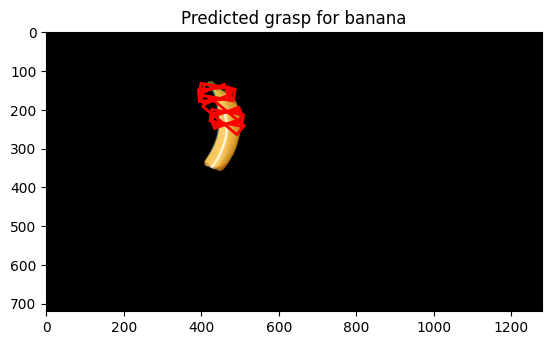

In [21]:
grasps_attributes = train_dataset[0]['grasp_attributes'].tolist()
grasps = [get_rotated_rectangle_corners(center_x, center_y, width, angle_rad) for (center_x,
                                                                                   center_y,
                                                                                   width,
                                                                                   angle_rad) in grasps_attributes
                                                                                    ]

image_rgb = (train_dataset[0]['rgb'] * 255).permute(1, 2, 0).numpy().astype(np.uint8)
visualise_image( image_rgb=image_rgb,
                polygons= [grasps[5],grasps[6],grasps[7],grasps[8],grasps[50],grasps[51],grasps[52],grasps[53]],
                caption = f'Predicted grasp for {train_dataset[0]["label"]}')

In [22]:
test_dataset = GraspDirectDataset(
                                    data_dir= './',
                                    prompts_file='test_prompts.json',
                                    grasps_file=None,
                                    objects_file=None,
                                    model=model
                                )

Object scissors in index 0 sucsss 
Object banana in index 1 not found in scene test_2
Object banana in index 2 not found in scene test_4
Object scissors in index 3 sucsss 
Object scissors in index 4 sucsss 
Object bowl in index 5 not found in scene test_8
Object mug in index 6 not found in scene test_10
Object knife in index 7 not found in scene test_12
Object scissors in index 8 sucsss 
Object mug in index 9 not found in scene test_15
Object scissors in index 10 sucsss 
Object scissors in index 11 sucsss 
Object scissors in index 12 sucsss 
Object scissors in index 13 sucsss 
Object scissors in index 14 sucsss 
Object bowl in index 15 not found in scene test_22
Object banana in index 16 not found in scene test_24
Object scissors in index 17 sucsss 
Object banana in index 18 not found in scene test_27
Object scissors in index 19 sucsss 
Object scissors in index 20 sucsss 
Object scissors in index 21 sucsss 
Object scissors in index 22 sucsss 
Object bowl in index 23 not found in scene 

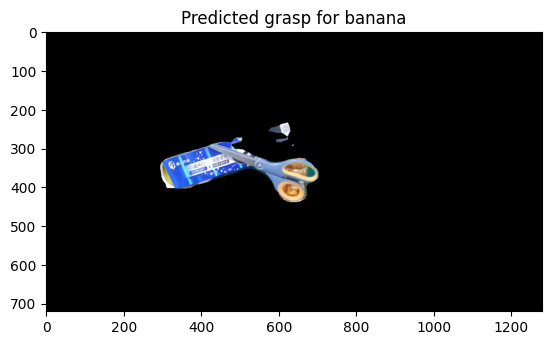

In [23]:
image_rgb = (test_dataset[0]['rgb'] * 255).permute(1, 2, 0).numpy().astype(np.uint8)
visualise_image( image_rgb=image_rgb,
                polygons= [],
                caption = f'Predicted grasp for {train_dataset[0]["label"]}')

## Evaluate Object Detector



---



In [ ]:
train_loader  = GraspDataLoader(dataset=train_dataset, batch_size=4, shuffle=True, num_workers=2)
len(train_loader)

1

**Define the Loss Function and Optimizer**

In [ ]:
import torch.optim as optim

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate of 0.001
loss_fn = nn.MSELoss()  # Mean Squared Error loss for regression


**Training Loop**

In [ ]:
# Training loop
num_epochs = 10  # Set the number of training epochs
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set the model to training mode

    for batch_idx, batch in enumerate(train_loader):
        print(batch)
        rgb_images =    batch['rgb'].to(device)  # RGB images for object detection
        depth_images =  batch['depth'].to(device)  # Depth images for grasp prediction
        grasp_targets = batch['grasp_attributes'].to(device)  # Ground truth grasp attributes
        object_labels = batch['label']  # Object labels (e.g., 'banana')

        optimizer.zero_grad()  # Zero the gradients

        # Iterate through each image in the batch
        for i in range(rgb_images.size(0)):
            # Forward pass through object detection and grasp prediction
            rgb_image = rgb_images[i]
            depth_image = depth_images[i]
            object_label = object_labels[i]

            grasp_predictions = model(rgb_image, depth_image, object_label)

            # Compute the loss between predicted grasp and ground truth grasp
            grasp_target = grasp_targets[i]
            loss = loss_fn(grasp_predictions, grasp_target)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")


{'rgb': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],


AssertionError: targets should not be none when in training mode

## Evaluate Grasps Detector

# Inference

In [ ]:
# Example input images (RGB and depth)
scan = 'test_1'
rgb_image_path = val_prompts[scan][0]
depth_image_path = val_prompts[scan][0].replace('rgb', 'depth')


# Load the RGB image and depth image
rgb_image = Image.open(rgb_image_path).convert('RGB')
depth_image = Image.open(depth_image_path).convert('L')
object_label =  val_prompts[scan][1]

# Run the forward pass (detect objects and predict grasps)
grasp_predictions = model(rgb_image, depth_image, object_label)

# Print the predicted grasp positions mapped to the original image
print(grasp_predictions)


In [ ]:
center_x, center_y, width, angle_rad = grasp_predictions[0]
rect = get_rotated_rectangle_corners(center_x, center_y, width, angle_rad)
rect

In [ ]:
visualise_image(
    file_name=rgb_image_path,
    polygons = [rect],
    caption = f'Predicted grasp for {object_label}'
    )



---

